In [10]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import locale
locale.setlocale(locale.LC_ALL, '' )

from scipy.stats import norm
from numpy import sqrt, array, exp


## Vasicek single-factor model

$$ X_i = \sqrt \rho Y + \sqrt{1-\rho}Z_i $$ 

X = shock to the return ~ N(0,1) <br>
Y, Z = market and firm-specific risk factors ~ N(0,1)  <br>
$\sqrt \rho$ = correlation btw firm and market factor  <br>

In [5]:
def generate_norms(N = 1, M = 1):
    """Generate standard normals: Y, Z."""
    Y, Z = np.random.randn(N).reshape(N,1), np.random.randn(N, M)
    return (Y, Z)

def vasicek_sf(rho, N=1, M=1): 
    """Compute exposure, X, using Vasicek single factor model."""
    Y, Z = generate_norms(N, M) # market, firm-specific risk factor
    X = np.sqrt(rho)*Y + np.sqrt(1-rho)*Z # company's exposure
    return (X, Y, Z)

def sim_portfolio_loss(EAD, LGD, PD, rho, N=1, M=1, mdl=vasicek_sf):
    """Simulate portfolio loss."""
    X, Y, Z = mdl(rho, N, M)
    threshold = np.array(norm.ppf(PD)).reshape(N,1) # threshold for loan/exposure
    sim_loss = sim_loss = np.sum(np.mean(LGD*EAD*(X < threshold).astype(int), axis=1))
    return (sim_loss)

def loss_pdf(x, p, rho):
    """"Loss pdf (pg4 Vasicek paper)."""
    invx, invp = norm.ppf(x), norm.ppf(p) 
    f = sqrt(1/rho-1) * exp(-1/(2*rho)*(sqrt(1-rho)*invx-invp)**2 + 0.5*invx**2)
    return (f)

def loss_cdf(x, p, rho):
    """"Loss cdf (Eq. 5, pg4 Vasicek paper)."""
    F = norm.cdf((sqrt(1-rho)*norm.ppf(x)-norm.ppf(p))/sqrt(rho))
    return (F)

def numc(x):
    # random fn for printing currency
    return (locale.currency(x, grouping=True))

# Test pdf: I = 1
# import scipy.integrate as integrate
# integrate.quad(portfolio_loss_pdf, 0, 1, args=(0.1, 0.2)) 

### Example from Vasicek paper
Portfolio loss distribution: p=0.02, rho=0.1

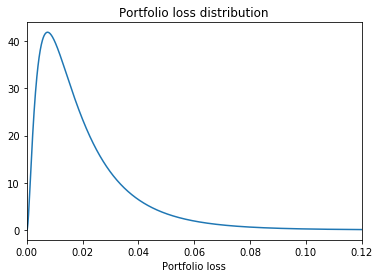

In [6]:
x = np.arange(0.0001, 1, 0.0001)
f = loss_pdf(x,0.02,0.1) # using p, rho from Vasicek paper
g = sns.lineplot(x, f).set(xlim=(0,0.12), 
                           title='Portfolio loss distribution', 
                           xlabel='Portfolio loss')


### Example from S. Schaefer (pg 16)
Portfolio loss distribution: p=1.5% (fixed) and rho=12%, 0.6%.

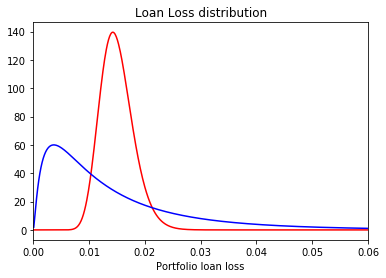

In [7]:
g = sns.lineplot(x, loss_pdf(x,0.015,0.006), color="red")
g = sns.lineplot(x, loss_pdf(x,0.015,0.12), color="blue").set(
    xlim=(0,0.06), title="Loan Loss distribution", xlabel='Portfolio loan loss')


### Example: expected and simulated portfolio loan loss

In [11]:
N, M = 1000, 20000
PD = np.repeat([0.00001, 0.01, 0.08, 0.0002], int(N/4))
LGD, EAD = np.repeat(0.5, N).reshape(N,1), np.repeat(1e6, N).reshape(N,1)
rho = 0.09
expd_loss = sum(PD.reshape(N) * LGD.reshape(N) * EAD.reshape(N))
print("Expected loss ", numc(expd_loss))
sim_loss = sim_portfolio_loss(EAD, LGD, PD, rho, N, M)
print("Simulated loss", numc(sim_loss))
print("Abs. Difference  ", numc(np.abs(expd_loss-sim_loss)))

Expected loss  $11,276,250.00
Simulated loss $10,918,700.00
Abs. Difference   $357,550.00


### Markit CDS data (from WRDS)


In [13]:
cds = pd.read_csv("cds_markit.csv", 
                  usecols=["date", "ticker", "rating6m", "spread6m", "recovery"])
cds = cds.dropna()
cds['lgd'] = 1 - cds['recovery']
cds['pd6m'] = cds['spread6m'] / cds['lgd'] # implied PD, given spread and recovery rate
print(cds.head(10))

# single loan
EAD = 1000000; N = 1
LGD, pd6m = cds.iloc[0,5:]
rho = 0.05
exp_loss = pd6m * LGD * EAD
print("Expected loss ", numc(exp_loss))
sim_loss = sim_portfolio_loss(EAD, LGD, np.repeat(pd6m,N).reshape(N,1), rho, N, M)
print("Simulated loss", numc(sim_loss))
print("Abs. Difference", numc(np.abs(exp_loss-sim_loss)))

      date ticker rating6m  spread6m  recovery  lgd      pd6m
0   1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
2   1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
3   1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
4   1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
5   1/1/13    IBM        A  0.000846       0.4  0.6  0.001409
6   1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
8   1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
9   1/1/13    IBM        A  0.000846       0.4  0.6  0.001409
10  1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
11  1/1/13    IBM        A  0.000867       0.4  0.6  0.001445
Expected loss  $866.83
Simulated loss $600.00
Abs. Difference $266.83


In [15]:
N, M = 1000, 20000
PD = np.repeat([0.00001, 0.01, 0.08, 0.0002], int(N/4))
LGD, EAD = np.repeat(0.5, N).reshape(N,1), np.repeat(1e6, N).reshape(N,1)
rho = 0.09
expd_loss = sum(PD.reshape(N) * LGD.reshape(N) * EAD.reshape(N))
print("Expected loss ", numc(expd_loss))
sim_loss = sim_portfolio_loss(EAD, LGD, PD, rho, N, M)
print("Simulated loss", numc(sim_loss))
print("Abs. Difference  ", numc(np.abs(expd_loss-sim_loss)))



Expected loss  $11,276,250.00
Simulated loss $11,608,475.00
Abs. Difference   $332,225.00
